# IMPORTING LIBRARIES

In [2]:
!pip install -U segmentation-models-pytorch

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from random import random

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import segmentation_models_pytorch as smp

In [4]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

# 1. PROBLEM STATEMENT

# 2. LOADING DATA

In [5]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dir = "drive/MyDrive/AV/data/"

In [7]:
x_train_dir = dir + 'train'
y_train_dir = dir + 'trainannot'

x_val_dir = dir + 'val'
y_val_dir = dir + 'valannot'

x_test_dir = dir + 'test'
y_test_dir = dir + 'testannot'

In [8]:
# DEFINE CUSTOM CLASS
class LaneDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        # ALL IMAGE NAMES
        self.image_names = os.listdir(images_dir)

        # SET TRAINING TYPE, TRANSFORMS, PREPROCESSING
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing = preprocessing

        # GET IMAGE AND MASK PATHS
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type == "train" or self.training_type == "val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, i):
        
        if self.training_type=="train" or self.training_type=="val":

            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # GETTING LANE MASK
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # DATA AUGMENTATION
            ## random horizontal flip
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            ## APPLY TRANSFORM
            image = self.transforms(image)
            mask = self.transforms(mask)

            ## APPLY PREPROCESSING
            if self.preprocessing:
                image = Compose([Normalize(mean = [0.485, 0.456, 0.406],
                                            std = [0.229, 0.224, 0.225])])(image)
            
            return image, mask
        
        else:
            image = Image.open(self.images_paths[i])
            
            # APPLY TRANSFORM
            image = self.transforms(image)

            # APPLY PREPROCESSING
            if self.preprocessing:
                image = Compose([Normalize(mean = [0.485, 0.456, 0.406],
                                            std = [0.229, 0.224, 0.225])])(image)  
            
            return image
        
    def __len__(self):
        return len(self.image_names)

# 3. VISUALIZE

In [9]:
# TRAIN DATALOADER WITHOUT PREPROCESSING
train_transforms = Compose([Resize((224, 224)), ToTensor()])

train_dataset = LaneDataset(
    x_train_dir, 
    y_train_dir, 
    transforms = train_transforms,
    preprocessing = False,
    training_type = 'train'
)

train_loader = DataLoader(
    train_dataset, 
    batch_size = 60,
    num_workers = 2
)

In [10]:
# LOADING ONE BATCH
for batch_x, batch_y in train_loader:
    break

In [11]:
batch_x.shape, batch_y.shape

(torch.Size([60, 3, 224, 224]), torch.Size([60, 1, 224, 224]))

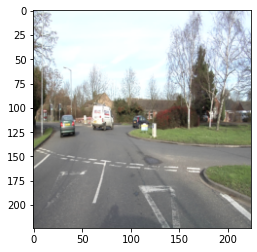

In [12]:
plt.imshow(np.transpose(batch_x[59], (1, 2, 0)))

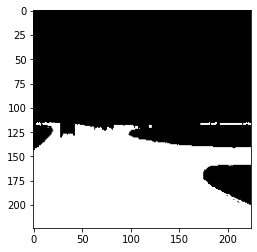

In [13]:
plt.imshow(batch_y[59].squeeze(), cmap='gray')

In [14]:
# TRAIN DATALOADER WITH PREPROCESSING
train_transforms = Compose([Resize((224, 224)), ToTensor()])

train_dataset = LaneDataset(
    x_train_dir, 
    y_train_dir, 
    transforms = train_transforms,
    preprocessing = True,
    training_type = 'train'
)

train_loader = DataLoader(
    train_dataset, 
    batch_size = 60,
    num_workers = 2
)

In [15]:
# LOADING ONE BATCH
for batch_x, batch_y in train_loader:
    break

In [16]:
batch_x.shape, batch_y.shape

(torch.Size([60, 3, 224, 224]), torch.Size([60, 1, 224, 224]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


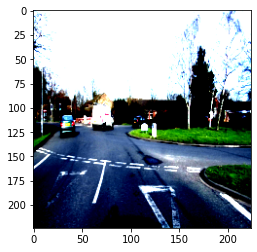

In [17]:
plt.imshow(np.transpose(batch_x[59], (1, 2, 0)))

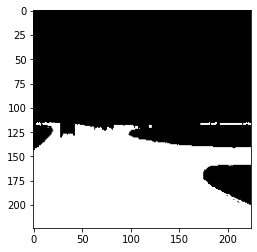

In [18]:
plt.imshow(batch_y[59].squeeze(), cmap='gray')

# 4. MODEL

In [19]:
# DEFINE DATA LOADERS

# TRAIN DATALOADER
train_dataset = LaneDataset(
    x_train_dir, 
    y_train_dir, 
    transforms = Compose([Resize((224, 224)), ToTensor()]),
    preprocessing = True,
    training_type = 'train'
)

train_loader = DataLoader(
    train_dataset, 
    batch_size = 16,
    num_workers = 4
)

# VALIDATION DATALOADER
val_dataset = LaneDataset(
    x_val_dir, 
    y_val_dir, 
    transforms = Compose([Resize((224, 224)), ToTensor()]),
    preprocessing = True,
    training_type = 'val'
)

val_loader = DataLoader(
    val_dataset, 
    batch_size = 16,
    num_workers = 4
)

# TEST DATA LOADER
test_dataset = LaneDataset(
    x_test_dir, 
    transforms = Compose([Resize((224, 224)), ToTensor()]),
    preprocessing = True,
    training_type = 'test'
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
# DEFINE U-Net MODEL WITH PRETRAINED DENSENET
model = smp.Unet(
    encoder_name = 'densenet121', 
    encoder_weights = 'imagenet', 
    classes = 1, 
    activation = 'sigmoid',
)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/hub/checkpoints/densenet121-fbdb23505.pth


  0%|          | 0.00/30.9M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


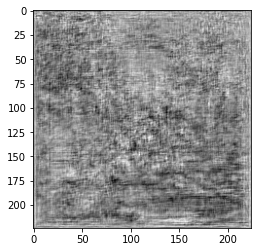

In [21]:
# CHECK FOR ITERATION OF LOOP
for batch_x, batch_y in train_loader:
    break

# CHECK MODEL ON ONE LOOP
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()
plt.imshow(output.squeeze(), cmap='gray')

In [22]:
criterion = smp.utils.losses.DiceLoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr = 1e-3)
metrics = [
    smp.utils.metrics.IoU(threshold = 0.5)
]

In [23]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss = criterion, 
    metrics = metrics, 
    optimizer = optimizer,
    device = 'cuda',
    verbose = True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss = criterion, 
    metrics = metrics, 
    device = 'cuda',
    verbose = True,
)

In [24]:
max_score = 0

for i in range(0, 15):
    train_logs = train_epoch.run(train_loader)
    val_logs = val_epoch.run(val_loader)
    print('Epoch: {} / {}'.format(i + 1, 15))
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, dir + '../best_model.pth')
        print('...^^^MODEL SAVED^^^...')

    # DECREASING LR TO FINETUNE MODEL
    if i+1 == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease learning rate to 1e-5')

train:   0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it, dice_loss - 0.1199, iou_score - 0.864]
Epoch: 1 / 15
...^^^MODEL SAVED^^^...
valid: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s, dice_loss - 0.07907, iou_score - 0.9084]
Epoch: 2 / 15
...^^^MODEL SAVED^^^...
valid: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s, dice_loss - 0.08176, iou_score - 0.8745]
Epoch: 3 / 15
valid: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s, dice_loss - 0.06709, iou_score - 0.8939]
Epoch: 4 / 15
valid: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s, dice_loss - 0.04298, iou_score - 0.9317]
Epoch: 5 / 15
...^^^MODEL SAVED^^^...
valid: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s, dice_loss - 0.03156, iou_score - 0.9494]
Epoch: 6 / 15
...^^^MODEL SAVED^^^...
valid: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s, dice_loss - 0.04294, iou_score - 0.9254]
Epoch: 7 / 15
valid: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s, dice_loss - 0.03745, iou_score - 0.9348]
Epoch: 8 / 15
valid: 100%|██████████| 7/7 [00:02<00:00, 

# INFERENCE

In [26]:
# LOAD BEST MODEL
model = torch.load(dir + '../best_model.pth')

In [48]:
# SAMPLE DATA
image = Image.open(dir + 'test/Seq05VD_f00030.png')
gt_mask = Image.open(dir + 'testannot/Seq05VD_f00030.png')

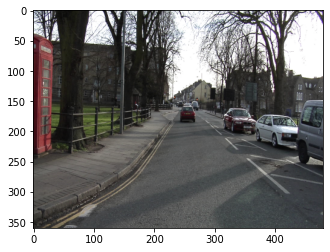

In [49]:
plt.imshow(image)

In [50]:
# PREPROCESS MASK
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

In [51]:
# APPLY DATA TRANSFORMATION
transform = Compose([Resize((224, 224)), ToTensor()])
image = transform(image)
image = Compose([Normalize(mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225])])(image)

gt_mask = transform(gt_mask)

In [58]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

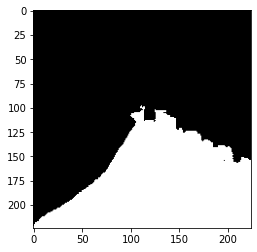

In [59]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

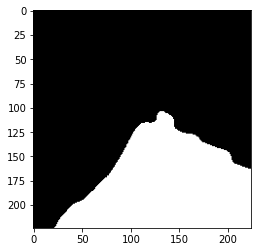

In [60]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [63]:
# FLATTEN PREDICTION AND GROUND TRUTH MASK
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

target = gt_mask.ravel().copy().astype(int)

# CLASS INDICES FOR LANE
pred_inds = pred == 1
target_inds = target == 1

# IOU SCORE
intersection = pred_inds[target_inds].sum()
union = pred_inds.sum() + target_inds.sum() - intersection
iou = (float(intersection) / float(max(union, 1)))
iou

0.9054385105340519